<a href="https://colab.research.google.com/github/ernestoaddiego/Intro_Credit_Fraud_Kaggle/blob/master/Wk3_FraudDetection_EAG_Sept19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import random

# Fraud Detection with Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iMsgC85SnIkR-OYtuBH0dfeUD-AWrS0Y)

By: [Ernesto Addiego-Guevara](https://www.linkedin.com/in/ernestoaddiego/)

*Dataset:* https://www.kaggle.com/c/ieee-fraud-detection/data 

*Resource:* https://www.data-blogger.com/2017/06/15/fraud-detection-a-simple-machine-learning-approach/ 

**Intent** 

Detecting credit card fraud using classic ML algorithms.

**Outline**
- Set Up & Data Import
- Exploratory Data Analysis
  - Feature Engineering
- Data Preparation
- Modelling & Results
- Concluding Remarks


# 1 Set Up & Data Import
First, I import the necessary packages we need. This is extracted from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/data). The data sources include:
- Sample Submission
- Test_identity
- Test_transaction
- Train_identity
- Train_transaction


In [0]:
# import both training datasets: one for identity and second for transactions
id_raw_df=pd.read_csv("train_identity.csv")
id_trans_df=pd.read_csv("train_transaction.csv")

In [5]:
id_raw_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
id_raw_df.shape

(144233, 41)

In [7]:
id_trans_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# key feature from transaction df is the column 'isFraud'
id_trans_df.shape

(328455, 394)

In [9]:
# intent: merge both training dataframes: identity & transaction
train_full_df=pd.merge(id_trans_df, id_raw_df, on='TransactionID', how='left')

train_full_df.shape

(328455, 434)

In [10]:
# and now working out the percentage of 'Fraud' transactions in the overall dataset
RatioisFraud = len(train_full_df[train_full_df["isFraud"]==1])/len(train_full_df)*100
print(RatioisFraud)

3.3794583732931454


## Treating NA Values
First, let's see the plot of % missing values versus each index.

Text(0, 0.5, '% Missing Value')

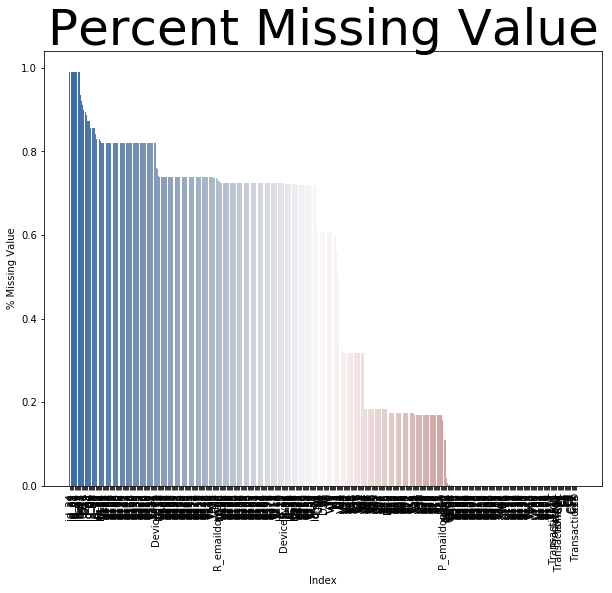

In [11]:
plt.figure(figsize=(10,8))
sns.barplot(y=train_full_df.isnull().sum().sort_values(ascending=False)/len(train_full_df),
            x=train_full_df.isnull().sum().sort_values(ascending=False).index,
            palette="vlag")
plt.title("Percent Missing Value", size=20)
plt.xticks(rotation=90)

plt.grid(False)
plt.axis('tight')
plt.xlabel('Index')
plt.ylabel('% Missing Value')

The plot shows a high number of columns that has over 70% of NaN values - these we can eliminate.

## Handling NAs
Two methods to deal with NAs:
* Drop data
* Impute/recode NAs

In [12]:
from sklearn.model_selection import train_test_split
# first, defining the columns with NaNs
columns_def=pd.DataFrame({"na_count":train_full_df.isnull().sum().sort_values(ascending=False)})
# then populating the column "missing" with the %Missing Value (higher value is worst)
columns_def["missing"]=columns_def["na_count"]/len(train_full_df)
columns_def.head()

,na_count,missing
id_24,325312,0.990431
id_25,325066,0.989682
id_07,325058,0.989658
id_08,325058,0.989658
id_21,325054,0.989645


In [13]:
# now, cycling thru various limits for % NaNs per column
range=[0.05,0.10,0.15,0.25,0.40,0.60,0.75]
print(range)

[0.05, 0.1, 0.15, 0.25, 0.4, 0.6, 0.75]


In [14]:
# and estimating the % of columns with the NaNs threshold range defined above
for i in range:
    print (columns_def[columns_def["missing"]<i].shape[0]/train_full_df.shape[1])

0.25806451612903225
0.25806451612903225
0.2626728110599078
0.41935483870967744
0.46543778801843316
0.4815668202764977
0.8248847926267281


In [15]:
limit=0.10 #i.e. only columns w. less than 25% NaNs will remain in the model

# and now selecting the final columns 
columns_final=columns_def[columns_def["missing"]<limit].index
train_full_df=train_full_df[train_full_df.columns.intersection(columns_final)]
train_full_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dealing with Categorical Features
First: show the columns; remove then; retrain dataset.

In [16]:
train_full_df[train_full_df.select_dtypes(include=['object']).columns]

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit
5,W,visa,debit
6,W,visa,debit
7,W,visa,debit
8,H,visa,debit
9,W,mastercard,debit


In [17]:
# use Pandas get_dummies to convert categorical data onto
card6_dummy_df=pd.get_dummies(train_full_df["card6"])

# then concatenate the converted column
train_full_df=pd.concat([train_full_df,card6_dummy_df],axis=1)

# now, drop the NaNs and use pandas get_numeric_data function
train_full_df=train_full_df._get_numeric_data()
train_full_df=train_full_df.dropna()

# and now working out the % proportion that 'Is Fraud'
len(train_full_df[train_full_df["isFraud"]==1])/len(train_full_df)*100

3.308918515936038

In [0]:
# now create the axes: y for the column with isFraud (predictor); x with the other columns
x_full_df=train_full_df.drop(["isFraud"],axis=1)
y_full_df=train_full_df["isFraud"]

In [0]:
# and now prepare the split test of the given data; choosing 50% split/test
# this is a regular line of code that we repeat for ML training
X_train, X_test, y_train, y_test=train_test_split(x_full_df,y_full_df,test_size=0.50)

# 2 Modeling
Now utilising 'sklearn' to do linear regeression on the dataset - aka apply the ML models.

First, importing the 'sklearn' libraries...

In [0]:
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [23]:
# now imploring the logistic regression algorithm onto the data model
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# and now scoring the linear regressor model with the 50% test data
lr.score(X_test, y_test)

0.9667988569792128

In [0]:
y_pred=lr.predict(X_test)

In [26]:
# now invoking pandas' crosstab to draw a 'confusion' matrix
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

Predicted,0,1,All
True,,,
0,155294,19,155313
1,5314,0,5314
All,160608,19,160627


In [27]:
# and now compute an 'accuracy' score
accuracy_score(y_test, y_pred)

0.9667988569792128

In [28]:
# and the 'recall' score
recall_score(y_test, y_pred)

0.0

<Figure size 720x576 with 0 Axes>

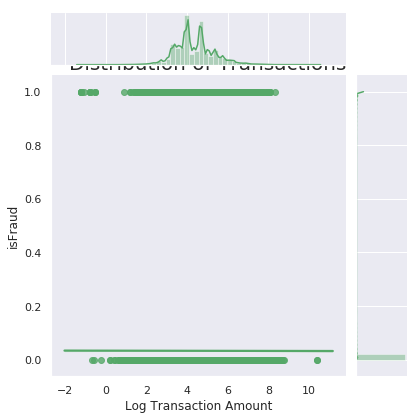

In [32]:
# finally, plotting the distribution of fraud transactions versus the transaction amount
plt.figure(figsize=(10,8))

train_full_df['log TransactionAmt'] = np.log(train_full_df['TransactionAmt'])

sns.set(style="darkgrid", color_codes=True)
sns.jointplot(data=train_full_df, x='log TransactionAmt',y='isFraud', color='g',kind='reg')

plt.title("Distribution of Transactions", loc='right', size=20)
plt.grid(False)
plt.axis('tight')
plt.xlabel('Log Transaction Amount')
plt.ylabel('isFraud')
plt.show()

# 3 Closing remarks

**Further steps:**
* Hot-code all the categorical values
* Implement alternative ML algorithms
* Drop less columns due to NaNs
* Impune values for columns